<a href="https://colab.research.google.com/github/shavindukesara/Telco-Churn-Predictor/blob/main/Telco%20Churn%20Predictor/source%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries imported successfully!
Dataset loaded: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  

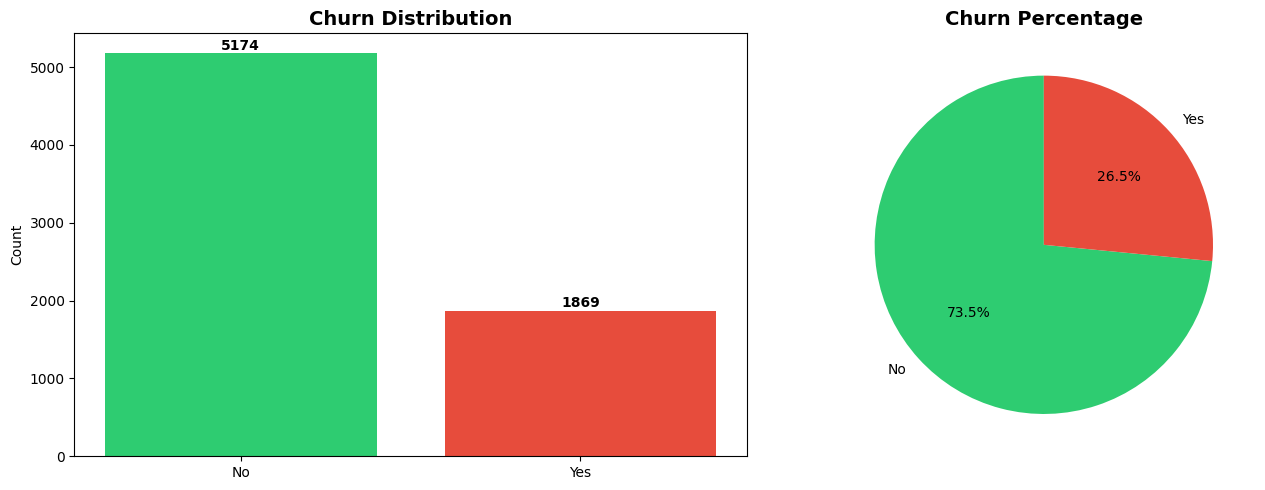


Insight: Imbalanced dataset - 73% No Churn, 27% Churn

Missing values in TotalCharges before conversion: 0
Missing values in TotalCharges after conversion: 11


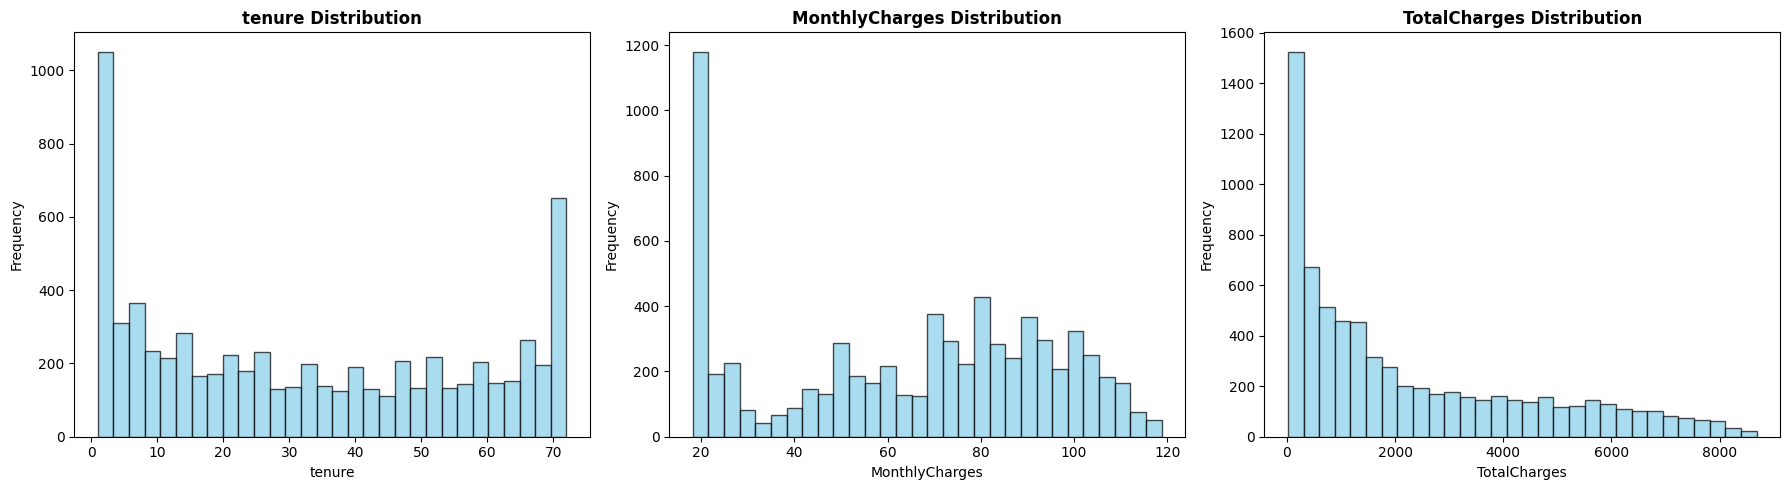

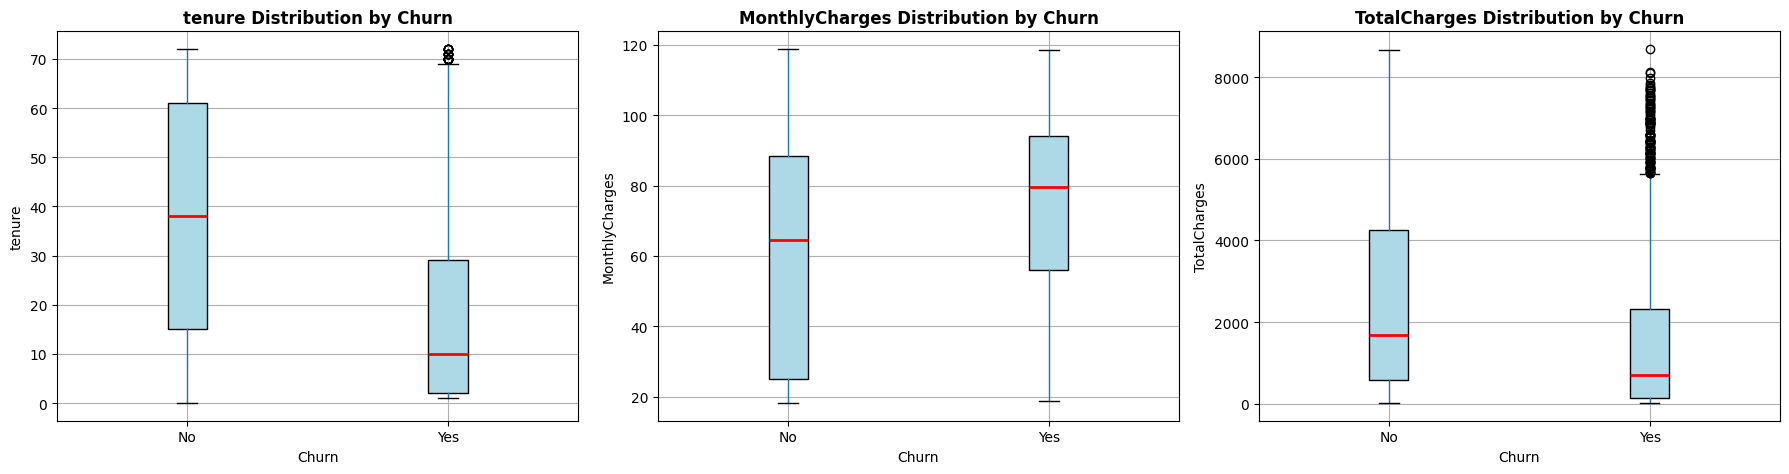


Insights:
- Churned customers have lower tenure (shorter relationship)
- Churned customers have higher monthly charges
- Churned customers have lower total charges


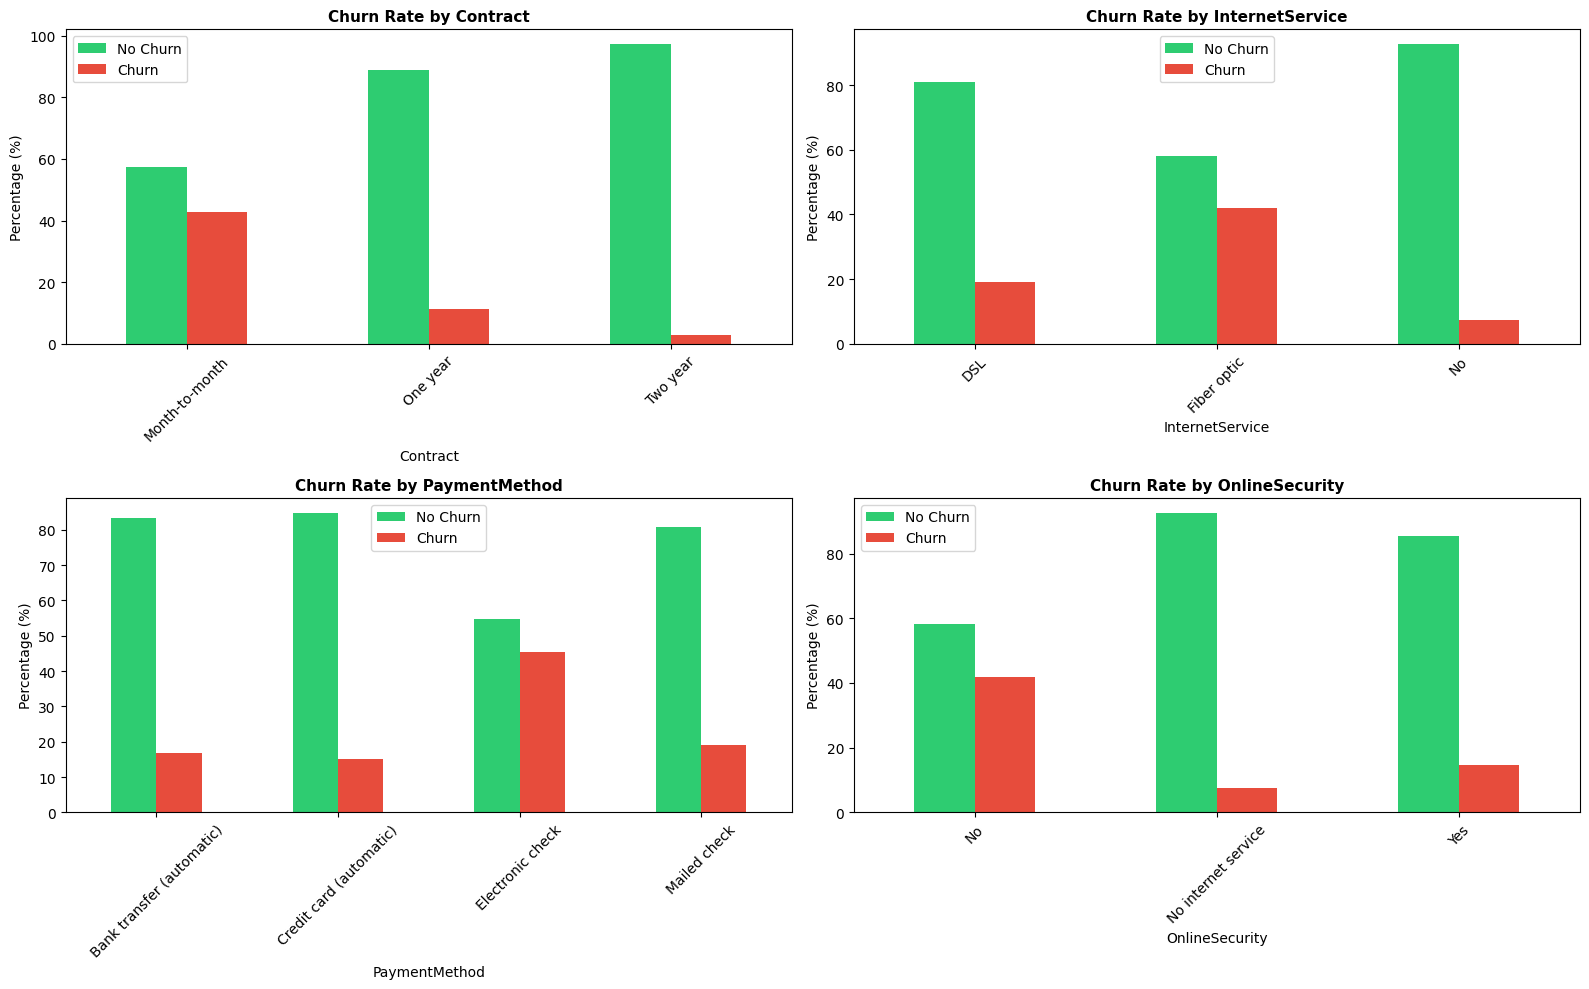


Key Findings:
- Month-to-month contracts: ~42% churn rate (HIGHEST)
- Fiber optic internet: Higher churn rate
- Electronic check payment: Higher churn rate
- No online security: Higher churn rate

--- Correlation Analysis ---


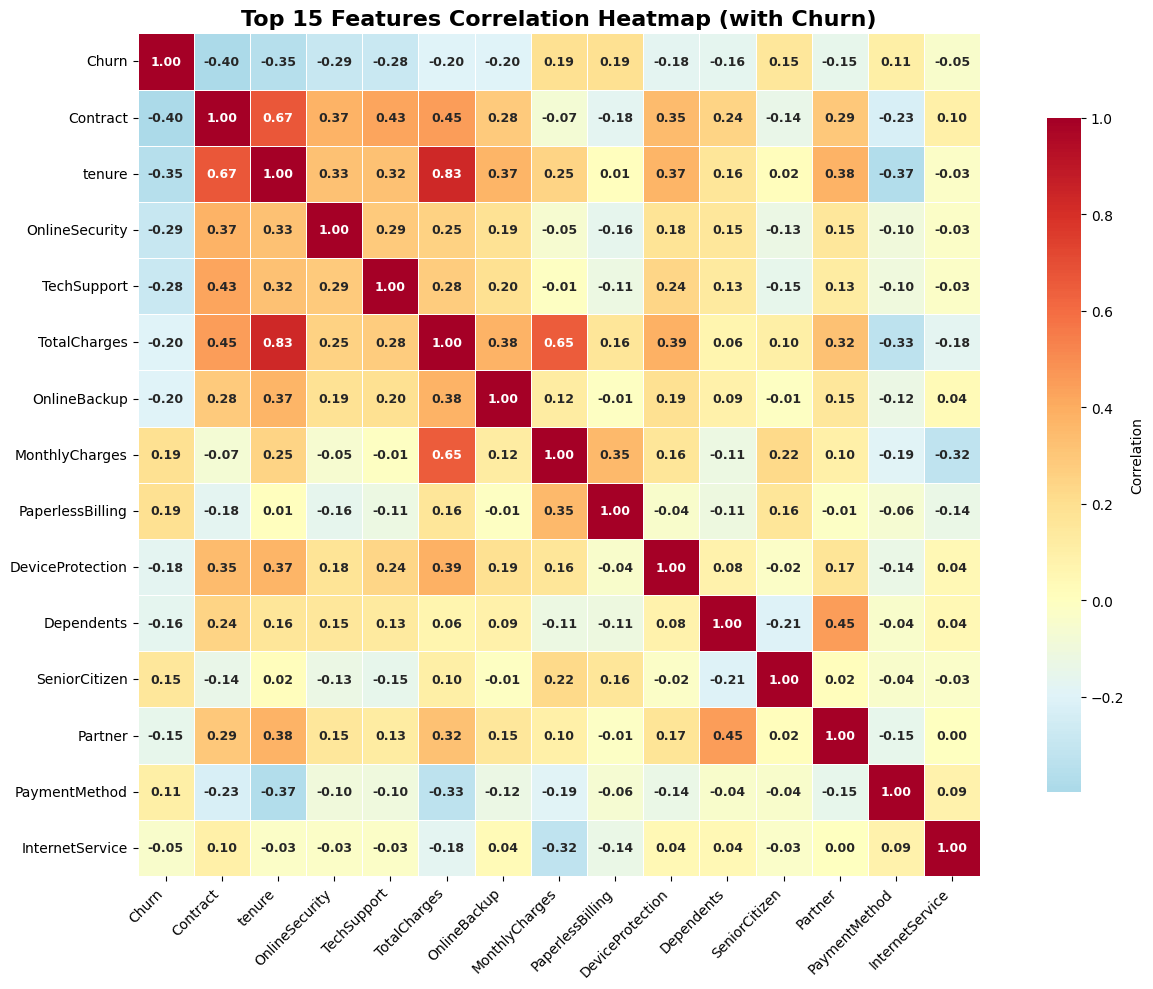


Top 15 Features Correlated with Churn:
Contract            0.396713
tenure              0.352229
OnlineSecurity      0.289309
TechSupport         0.282492
TotalCharges        0.199037
OnlineBackup        0.195525
MonthlyCharges      0.193356
PaperlessBilling    0.191825
DeviceProtection    0.178134
Dependents          0.164221
SeniorCitizen       0.150889
Partner             0.150448
PaymentMethod       0.107062
InternetService     0.047291
StreamingMovies     0.038492
Name: Churn, dtype: float64


<Figure size 1000x600 with 0 Axes>

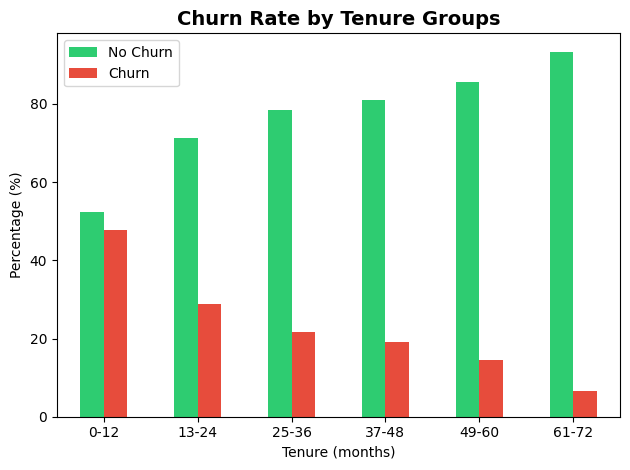


Insight: Churn rate decreases significantly with tenure

KEY FINDINGS:
1. Dataset is imbalanced (73% No Churn, 27% Churn)
2. Contract type is strongest predictor (month-to-month highest churn)
3. Tenure inversely correlated with churn
4. Monthly charges positively correlated with churn
5. Internet service type and payment method affect churn
6. Customers without add-on services churn more


DATA PREPROCESSING
Missing TotalCharges: 11
Features shape: (7043, 30)
Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Training set: (5634, 30)
Test set: (1409, 30)
Preprocessing complete
Fitting 5 folds for each of 800 candidates, totalling 4000 fits

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best CV ROC-AUC: 0.8271

--- DECISION TREE RESULTS ---
              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.87      1035
       Churn       0.63      0.58 

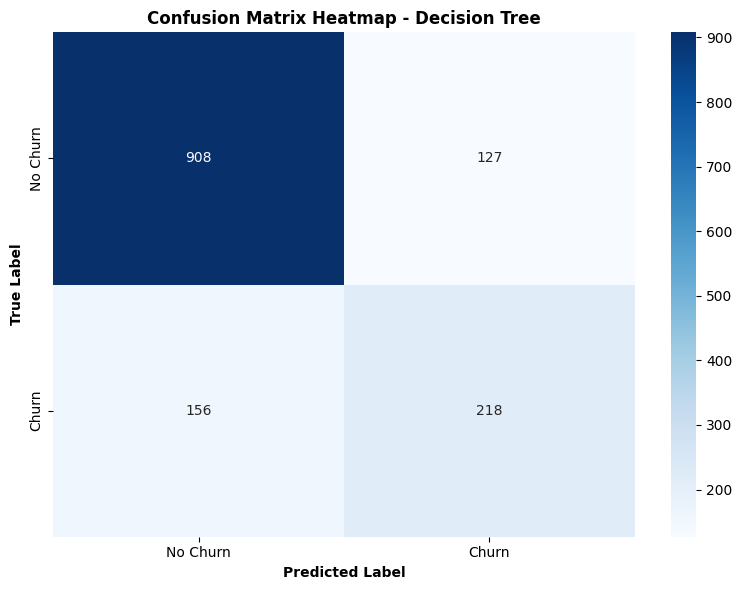


Metrics:
  Accuracy: 0.7991
  Precision: 0.6319
  Recall: 0.5829
  F1-Score: 0.6064
  ROC-AUC: 0.8295

Features used (non-zero importance): 12/30
Sum of importances: 1.000000

Top 10 Important Features:
                        Feature  Importance
              Contract_Two year    0.332713
              Contract_One year    0.211123
                         tenure    0.136433
    InternetService_Fiber optic    0.117352
                 MonthlyCharges    0.062898
                   TotalCharges    0.052240
 PaymentMethod_Electronic check    0.034107
            StreamingMovies_Yes    0.030008
StreamingTV_No internet service    0.011939
 MultipleLines_No phone service    0.003865

Contract Interpretation (baseline = Month-to-month):
  Contract_Two year: 0.3327 (vs Month-to-month baseline)
  Contract_One year: 0.2111 (vs Month-to-month baseline)


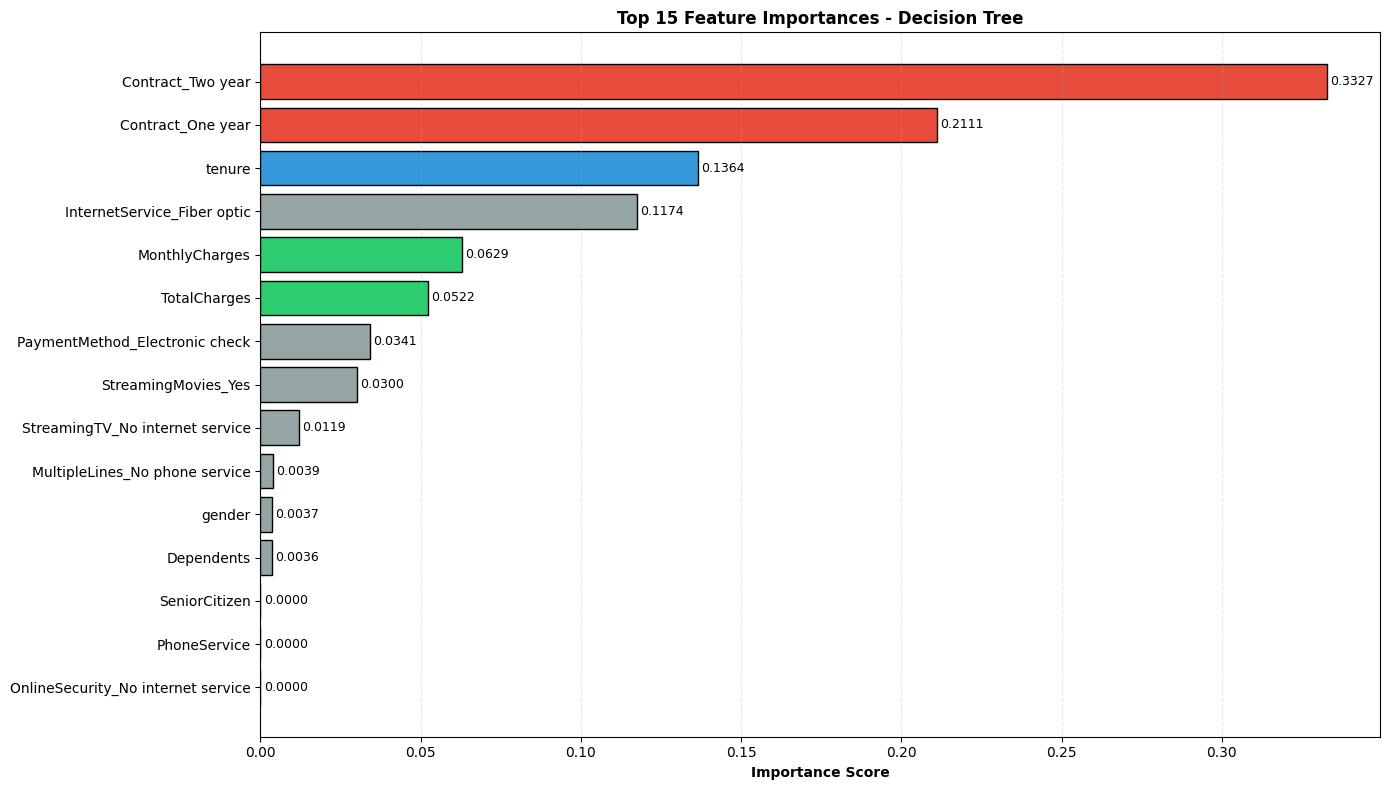

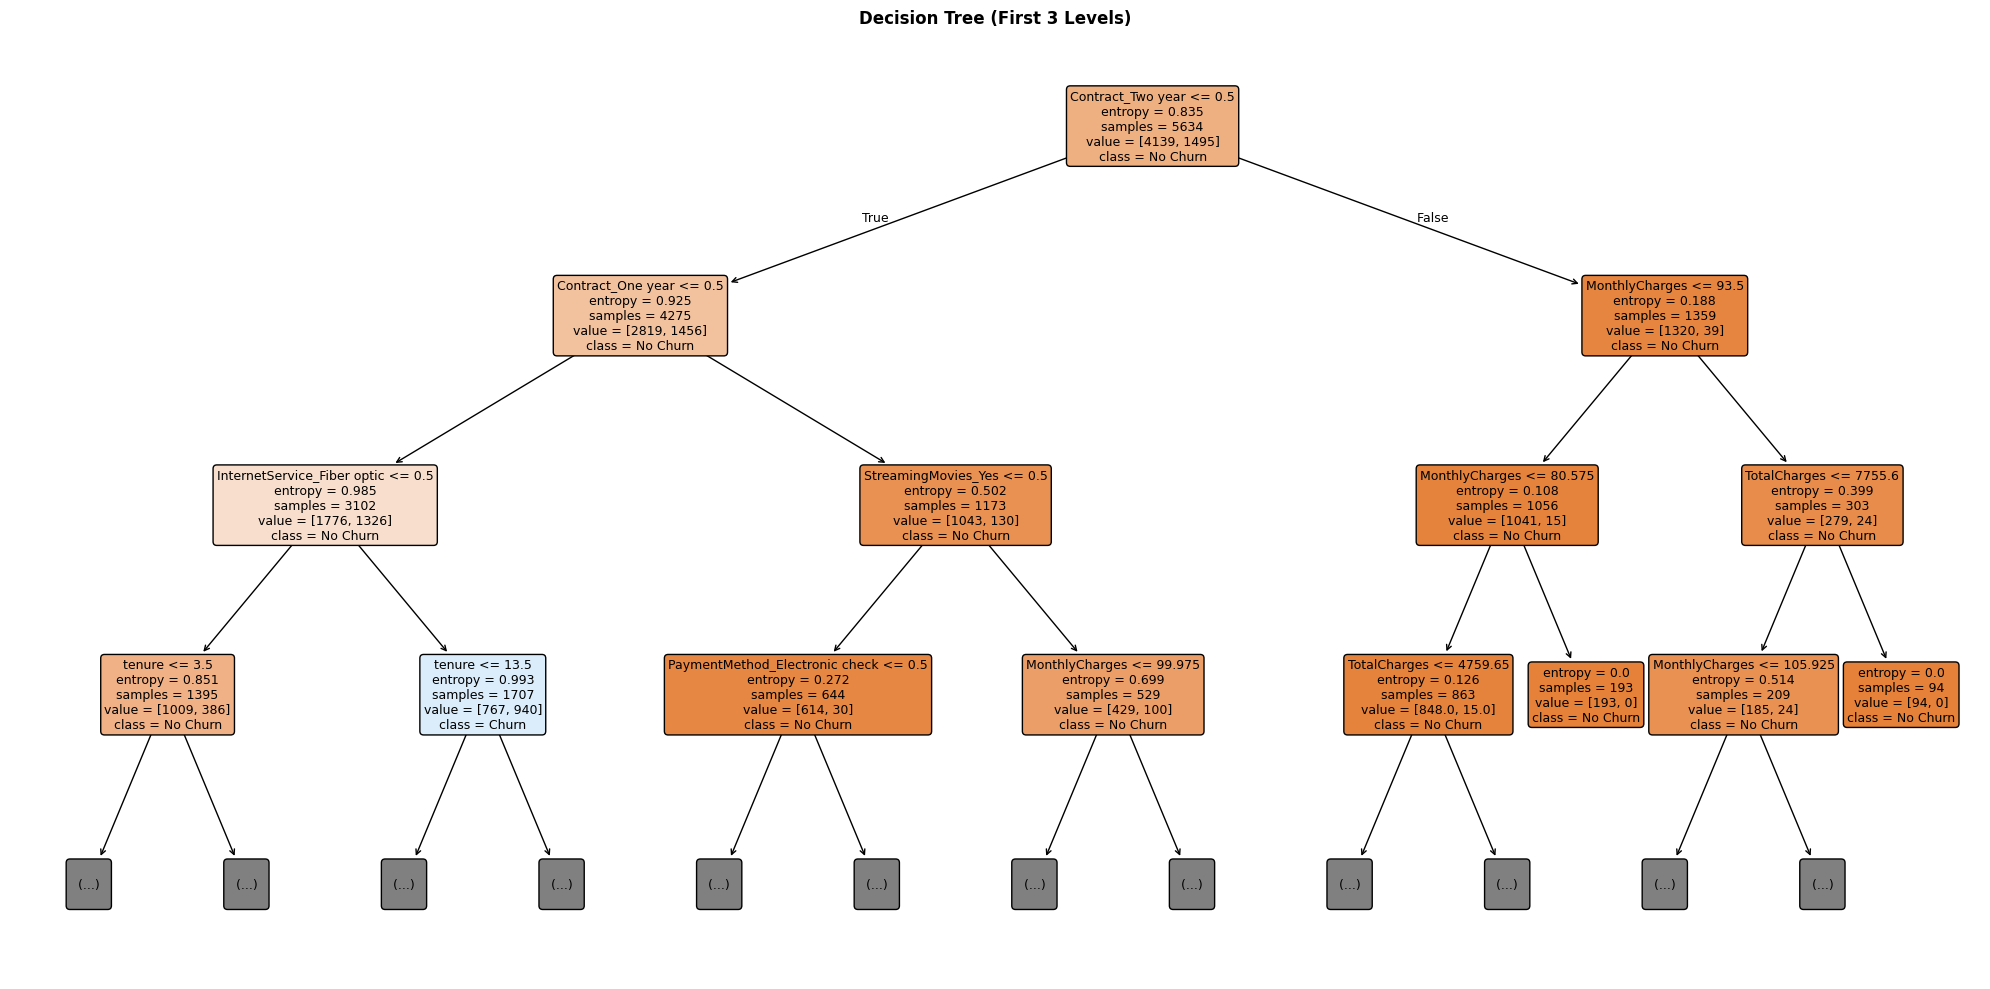


DECISION TREE DIAGNOSTICS
Tree depth: 6
Number of leaves: 43

First 5 splits in tree:
  Node 0: Contract_Two year <= 0.5000
  Node 1: Contract_One year <= 0.5000
  Node 2: InternetService_Fiber optic <= 0.5000
  Node 3: tenure <= 3.5000
  Node 4: StreamingTV_No internet service <= 0.5000

Cross-check - Features used in tree splits:
Unique features in tree: 12
Top features in tree:
  • Contract_Two year
  • Contract_One year
  • InternetService_Fiber optic
  • tenure
  • StreamingTV_No internet service
Class Weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}

Hyperparameter Tuning...
Testing LR=0.001, Batch=32
  Validation AUC: 0.8297
Testing LR=0.0005, Batch=64
  Validation AUC: 0.8357

Best Config: LR=0.0005, Batch=64

Training final model...
Epoch 1/80
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4662 - auc: 0.5575 - loss: 0.9290 - val_accuracy: 0.6495 - val_auc: 0.7637 - val_loss: 0.6518 - learning_rate: 5.0000e-04
Epoch 2/80
71/71 ━━━━━━━━━━━━

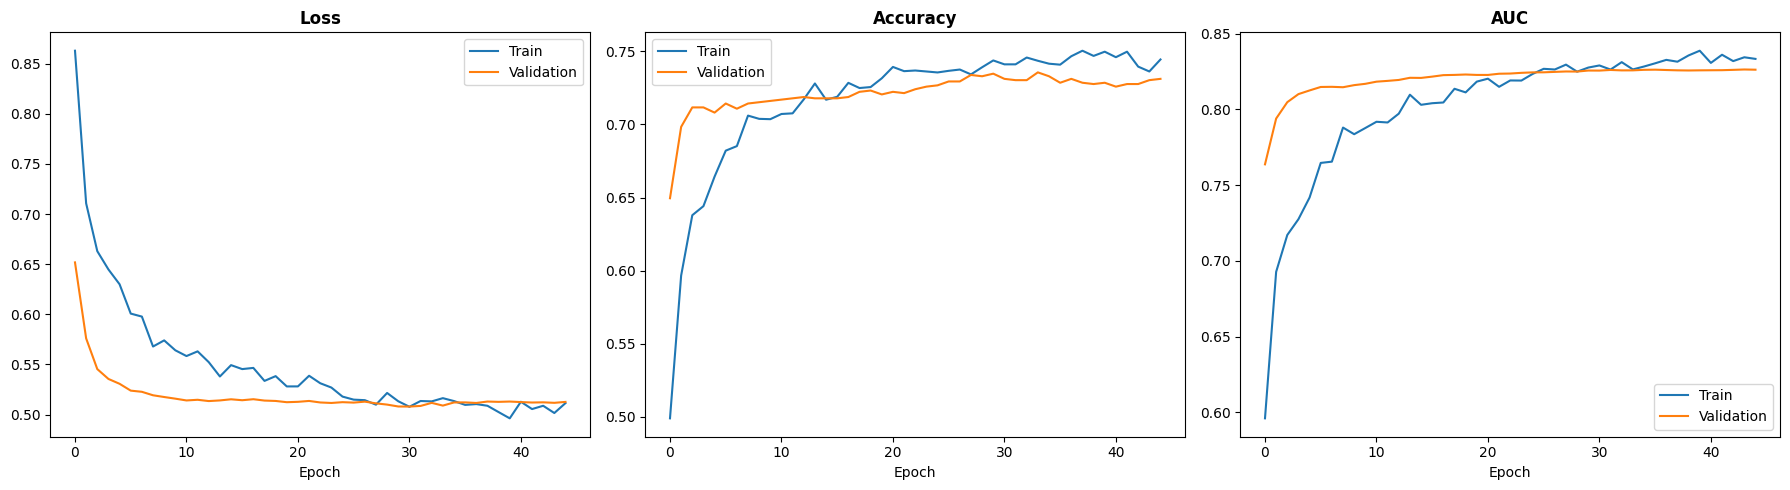

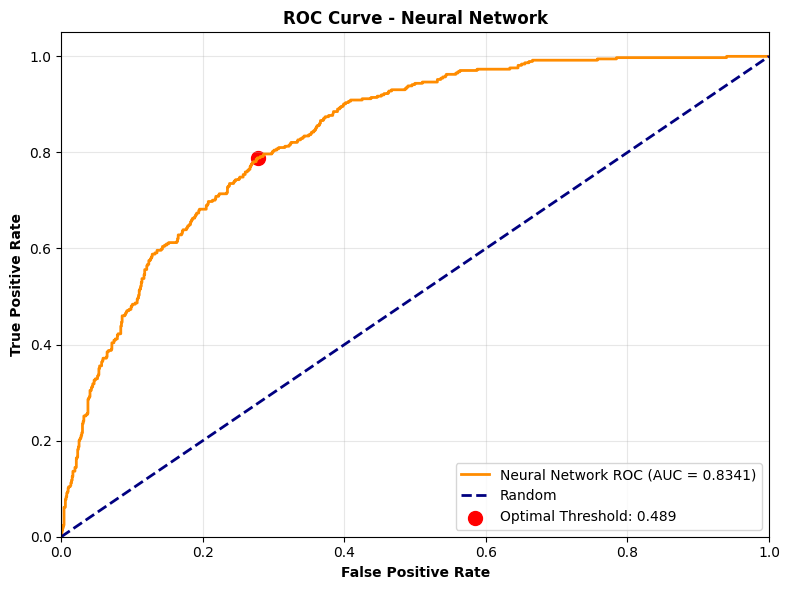


MODEL COMPARISON

   Metric  Decision Tree  Neural Network
 Accuracy       0.799148        0.739532
Precision       0.631884        0.506024
   Recall       0.582888        0.786096
 F1-Score       0.606398        0.615707
  ROC-AUC       0.829549        0.834129


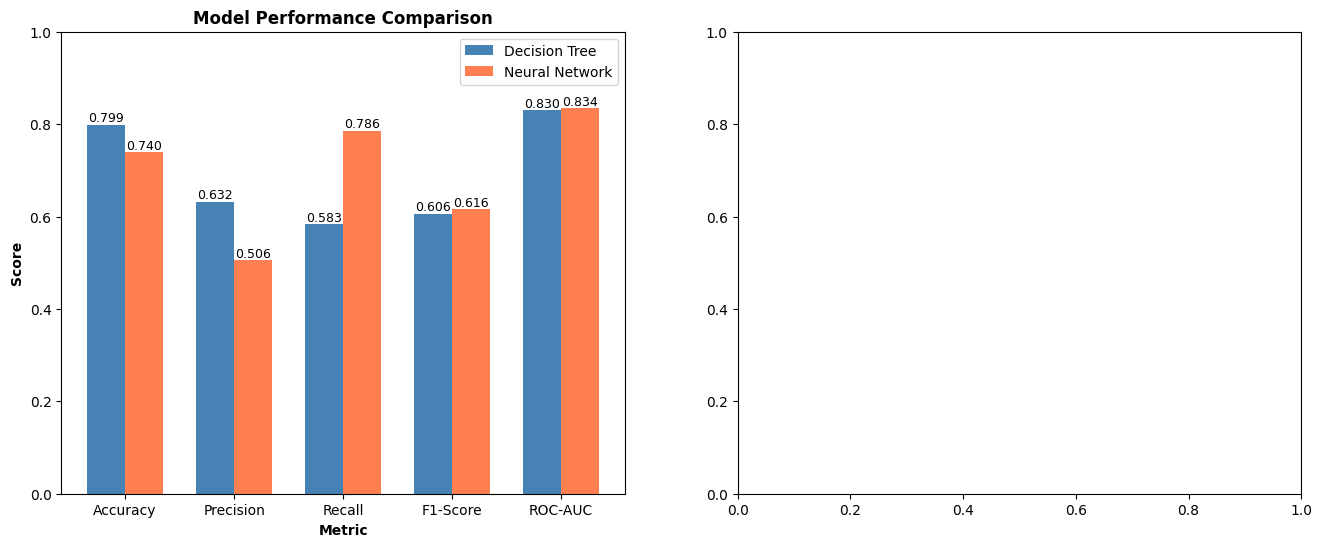

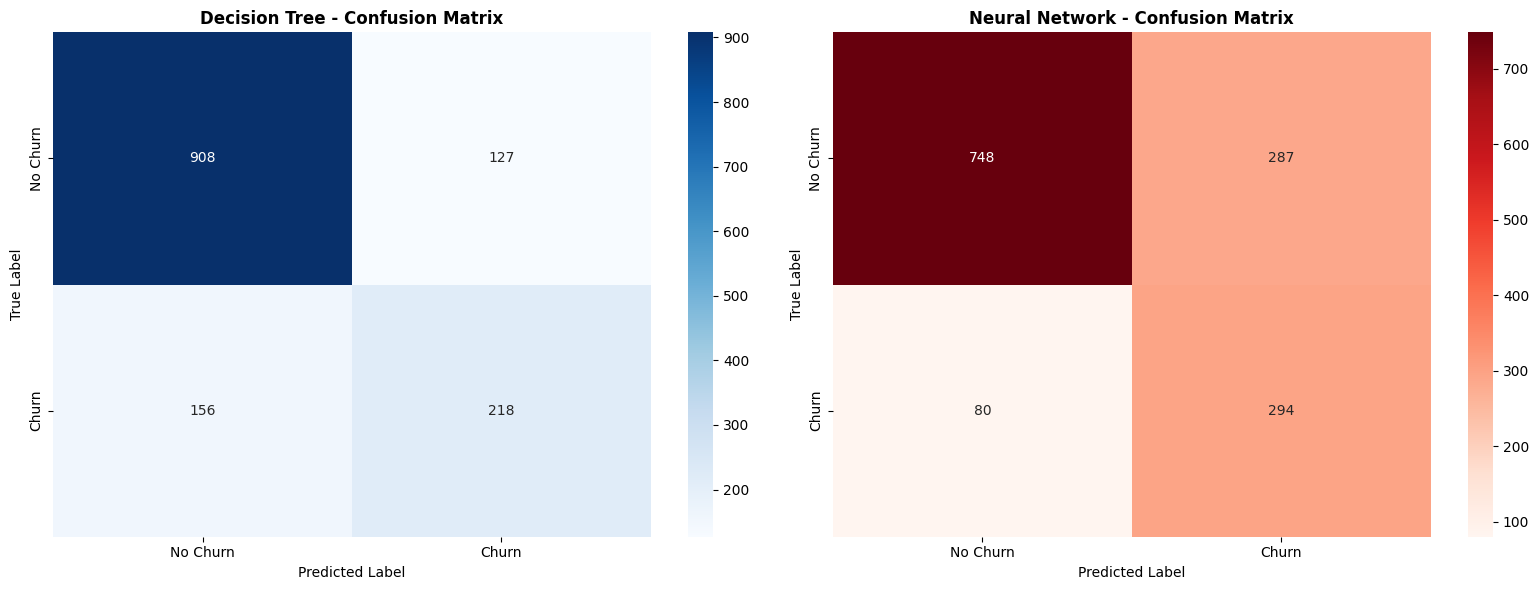

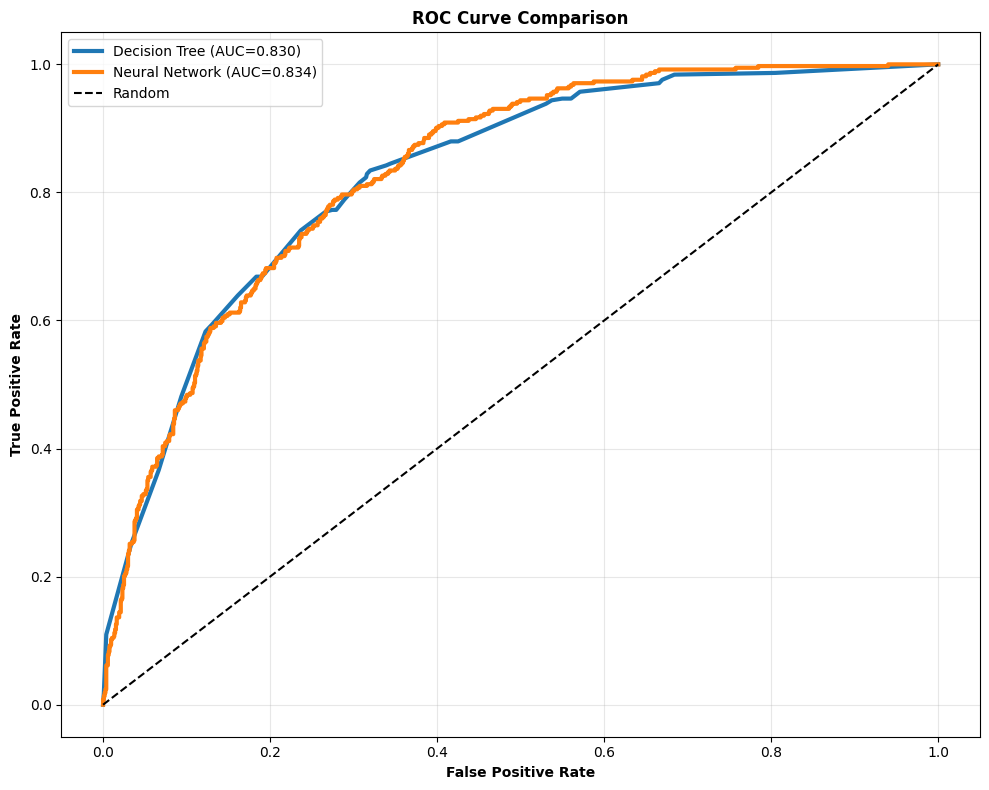


FINAL SUMMARY

Best Model: Neural Network

Decision Tree - ROC-AUC: 0.8295
Neural Network - ROC-AUC: 0.8341


In [19]:
# ================================================================================
# TELCO CUSTOMER CHURN PREDICTION
# ================================================================================

!pip install -q scikit-learn tensorflow pandas numpy matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, auc)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

# Load dataset from URL
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

print(f"Dataset loaded: {df.shape}")
print(df.head())

# ================================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ================================================================================

# Basic Info
print("\n--- Dataset Info ---")
df.info()
print(f"\nDataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Target Variable Analysis
print("\n--- Target Variable Distribution ---")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {df['Churn'].value_counts(normalize=True)['Yes']*100:.2f}%")

# Visualization 1: Churn Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
churn_counts = df['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInsight: Imbalanced dataset - 73% No Churn, 27% Churn")

# Numerical Features Analysis
print(f"\nMissing values in TotalCharges before conversion: {df['TotalCharges'].isnull().sum()}")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Missing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

# For EDA visualizations, use non-null values
df_clean = df.dropna(subset=['TotalCharges'])

# Update the histograms to use df_clean:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    axes[idx].hist(df_clean[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualization 3: Numerical Features vs Churn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    df.boxplot(column=col, by='Churn', ax=axes[idx], patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    # Remove the automatic "Boxplot grouped by Churn" title
    axes[idx].set_title(f'{col} Distribution by Churn', fontsize=12, fontweight='bold')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nInsights:")
print("- Churned customers have lower tenure (shorter relationship)")
print("- Churned customers have higher monthly charges")
print("- Churned customers have lower total charges")

# Categorical Features Analysis
# Visualization 4: Key Features vs Churn
key_features = ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    churn_data = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    churn_data.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Churn Rate by {feature}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("- Month-to-month contracts: ~42% churn rate (HIGHEST)")
print("- Fiber optic internet: Higher churn rate")
print("- Electronic check payment: Higher churn rate")
print("- No online security: Higher churn rate")

# Correlation Analysis
print("\n--- Correlation Analysis ---")
df_corr = df.copy()

# Encode categorical variables for correlation
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

for col in categorical_cols:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

df_corr = df_corr.drop('customerID', axis=1)
df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')
df_corr['TotalCharges'] = df_corr['TotalCharges'].fillna(df_corr['TotalCharges'].median())

correlation_matrix = df_corr.corr()

# Top correlations with Churn
corr_with_churn = correlation_matrix['Churn'].abs().sort_values(ascending=False)
top_features = corr_with_churn.head(15).index.tolist()
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Visualization 5: Top Features Correlation Heatmap with better colors
plt.figure(figsize=(14, 10))
sns.heatmap(top_corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='RdYlBu_r',  # Better color scheme: Red-Yellow-Blue reversed
            center=0,
            square=True,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
            annot_kws={'size': 9, 'weight': 'bold'})

plt.title('Top 15 Features Correlation Heatmap (with Churn)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


churn_corr = correlation_matrix['Churn'].abs().sort_values(ascending=False)
print("\nTop 15 Features Correlated with Churn:")
print(churn_corr[1:16])

# Visualization 6: Tenure Groups Analysis
tenure_bins = [0, 12, 24, 36, 48, 60, 72]
df['TenureGroup'] = pd.cut(df['tenure'], bins=tenure_bins, labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
tenure_churn = pd.crosstab(df['TenureGroup'], df['Churn'], normalize='index') * 100

plt.figure(figsize=(10, 6))
tenure_churn.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Churn Rate by Tenure Groups', fontsize=14, fontweight='bold')
plt.xlabel('Tenure (months)')
plt.ylabel('Percentage (%)')
plt.legend(['No Churn', 'Churn'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInsight: Churn rate decreases significantly with tenure")

print("""
KEY FINDINGS:
1. Dataset is imbalanced (73% No Churn, 27% Churn)
2. Contract type is strongest predictor (month-to-month highest churn)
3. Tenure inversely correlated with churn
4. Monthly charges positively correlated with churn
5. Internet service type and payment method affect churn
6. Customers without add-on services churn more
""")

# =============================================================================
# DATA PREPROCESSING
# =============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

df_processed = df.copy()

# Handle missing values
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
print(f"Missing TotalCharges: {df_processed['TotalCharges'].isnull().sum()}")

# direct assignment instead of inplace=True
df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median())

# Drop non-predictive columns
df_processed = df_processed.drop(['customerID', 'TenureGroup'], axis=1, errors='ignore')

# Encode binary variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

multi_class_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
df_processed = pd.get_dummies(df_processed, columns=multi_class_cols, drop_first=True, dtype=int)

# Encode target
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Preprocessing complete")

# =============================================================================
# DECISION TREE MODEL
# =============================================================================

# Hyperparameter tuning
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, None]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

dt_final = grid_search.best_estimator_
y_pred_dt = dt_final.predict(X_test)
y_pred_proba_dt = dt_final.predict_proba(X_test)[:, 1]

print("\n--- DECISION TREE RESULTS ---")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"Confusion Matrix:\n{cm_dt}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix Heatmap - Decision Tree', fontweight='bold')
plt.tight_layout()
plt.show()

dt_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_dt)
}

print("\nMetrics:")
for metric, value in dt_metrics.items():
    print(f"  {metric}: {value:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Importance': dt_final.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeatures used (non-zero importance): {(feature_importance['Importance'] > 0).sum()}/{len(feature_importance)}")
print(f"Sum of importances: {feature_importance['Importance'].sum():.6f}")

print("\nTop 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

print("\nContract Interpretation (baseline = Month-to-month):")
for feature in ['Contract_Two year', 'Contract_One year']:
    if feature in feature_importance['Feature'].values:
        imp = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].values[0]
        print(f"  {feature}: {imp:.4f} (vs Month-to-month baseline)")

plt.figure(figsize=(14, 8))
top_n = min(15, len(feature_importance))
top_features = feature_importance.head(top_n)

colors = []
for feature in top_features['Feature']:
    if 'Contract' in feature:
        colors.append('#e74c3c')
    elif 'tenure' in feature.lower():
        colors.append('#3498db')
    elif 'charge' in feature.lower():
        colors.append('#2ecc71')
    else:
        colors.append('#95a5a6')

bars = plt.barh(range(top_n), top_features['Importance'], color=colors, edgecolor='black')

for i, (imp, feature) in enumerate(zip(top_features['Importance'], top_features['Feature'])):
    plt.text(imp + 0.001, i, f'{imp:.4f}', va='center', fontsize=9)

plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title(f'Top {top_n} Feature Importances - Decision Tree', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(dt_final, max_depth=3, feature_names=X_train.columns.tolist(),
          class_names=['No Churn', 'Churn'], filled=True, rounded=True, fontsize=9)
plt.title('Decision Tree (First 3 Levels)', fontweight='bold')
plt.tight_layout()
plt.show()

# Tree diagnostics
print("\n" + "="*80)
print("DECISION TREE DIAGNOSTICS")
print("="*80)

print(f"Tree depth: {dt_final.get_depth()}")
print(f"Number of leaves: {dt_final.get_n_leaves()}")

# Verify tree structure
tree = dt_final.tree_
feature_indices = tree.feature
print("\nFirst 5 splits in tree:")
for i in range(min(5, tree.node_count)):
    if feature_indices[i] != -2:
        feat_name = X_train.columns[feature_indices[i]]
        threshold = tree.threshold[i]
        print(f"  Node {i}: {feat_name} <= {threshold:.4f}")

# Cross-check: Feature importance vs tree splits
print("\nCross-check - Features used in tree splits:")
used_features = []
for i in range(tree.node_count):
    if feature_indices[i] != -2:
        feat_name = X_train.columns[feature_indices[i]]
        if feat_name not in used_features:
            used_features.append(feat_name)

print(f"Unique features in tree: {len(used_features)}")
print("Top features in tree:")
for feat in used_features[:5]:
    print(f"  • {feat}")

# =============================================================================
# NEURAL NETWORK MODEL
# =============================================================================

# Calculating class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print(f"Class Weights: {class_weights}")

# Build model
def create_nn_model(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.5),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(16, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Hyperparameter tuning
print("\nHyperparameter Tuning...")
configs = [
    {'learning_rate': 0.001, 'batch_size': 32},
    {'learning_rate': 0.0005, 'batch_size': 64},
]

best_score = 0
best_config = None

for config in configs:
    print(f"Testing LR={config['learning_rate']}, Batch={config['batch_size']}")

    model = create_nn_model(X_train_scaled.shape[1], config['learning_rate'])

    history = model.fit(
        X_train_scaled, y_train,
        epochs=30,
        batch_size=config['batch_size'],
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
        ],
        verbose=0
    )

    _, _, val_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"  Validation AUC: {val_auc:.4f}")

    if val_auc > best_score:
        best_score = val_auc
        best_config = config
        best_model = model

print(f"\nBest Config: LR={best_config['learning_rate']}, Batch={best_config['batch_size']}")

# Train final model
print("\nTraining final model...")
nn_final = create_nn_model(X_train_scaled.shape[1], best_config['learning_rate'])

history = nn_final.fit(
    X_train_scaled, y_train,
    epochs=80,
    batch_size=best_config['batch_size'],
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1)
    ],
    verbose=1
)

# Evaluate
y_pred_proba_nn = nn_final.predict(X_test_scaled).flatten()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_nn)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

y_pred_nn = (y_pred_proba_nn > optimal_threshold).astype(int)

print("\n--- NEURAL NETWORK RESULTS ---")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

cm_nn = confusion_matrix(y_test, y_pred_nn)
print(f"Confusion Matrix:\n{cm_nn}")

nn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn),
    'Recall': recall_score(y_test, y_pred_nn),
    'F1-Score': f1_score(y_test, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_nn)
}

print("\nMetrics:")
for metric, value in nn_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_title('Accuracy', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].legend()

axes[2].plot(history.history['auc'], label='Train')
axes[2].plot(history.history['val_auc'], label='Validation')
axes[2].set_title('AUC', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout()
plt.show()

# ROC Curve for Neural Network
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Neural Network ROC (AUC = {nn_metrics["ROC-AUC"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100,
            label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve - Neural Network', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# MODEL COMPARISON
# =============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [dt_metrics['Accuracy'], dt_metrics['Precision'],
                      dt_metrics['Recall'], dt_metrics['F1-Score'], dt_metrics['ROC-AUC']],
    'Neural Network': [nn_metrics['Accuracy'], nn_metrics['Precision'],
                       nn_metrics['Recall'], nn_metrics['F1-Score'], nn_metrics['ROC-AUC']]
})

print("\n" + comparison_df.to_string(index=False))

# Visualization: Metrics Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(comparison_df['Metric']))
width = 0.35

bars1 = axes[0].bar(x - width/2, comparison_df['Decision Tree'], width,
                    label='Decision Tree', color='steelblue')
bars2 = axes[0].bar(x + width/2, comparison_df['Neural Network'], width,
                    label='Neural Network', color='coral')

axes[0].set_xlabel('Metric', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Metric'])
axes[0].legend()
axes[0].set_ylim(0, 1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Decision Tree - Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Plot Neural Network Confusion Matrix
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Neural Network - Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, linewidth=3, label=f'Decision Tree (AUC={dt_metrics["ROC-AUC"]:.3f})')
plt.plot(fpr_nn, tpr_nn, linewidth=3, label=f'Neural Network (AUC={nn_metrics["ROC-AUC"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve Comparison', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

winner = 'Neural Network' if nn_metrics['ROC-AUC'] > dt_metrics['ROC-AUC'] else 'Decision Tree'
print(f"\nBest Model: {winner}")
print(f"\nDecision Tree - ROC-AUC: {dt_metrics['ROC-AUC']:.4f}")
print(f"Neural Network - ROC-AUC: {nn_metrics['ROC-AUC']:.4f}")

